In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split,cross_val_score,KFold,RepeatedKFold,GridSearchCV
from scipy.stats import pearsonr,ttest_ind,levene
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 导入数据+预处理

In [2]:
#导入数据
csv_x0 = './0x.csv'#GTVnx敏感组的特征表格
csv_x1 = './1x.csv'#GTVnx抵抗组的特征表格
csv_d0 = './0d.csv'#GTVnd敏感组的特征表格
csv_d1 = './1d.csv'#GTVnd抵抗组的特征表格
data_x0 = pd.read_csv(csv_x0)
data_x1 = pd.read_csv(csv_x1)
data_d0 = pd.read_csv(csv_d0)
data_d1 = pd.read_csv(csv_d1)
data_x = pd.concat([data_x0,data_x1])#GTVnx汇总
data_d = pd.concat([data_d0,data_d1])#GTVnd汇总
print(data_x0.shape,data_x1.shape,data_d0.shape,data_d1.shape)

(12, 3468) (11, 3468) (12, 3468) (11, 3468)


In [9]:
#数据集处理
data_x = shuffle(data_x)
data_x.index = range(len(data_x))
X_x = data_x[data_x.columns[1:]]
# 标准化+整理GTVnx
scaler = StandardScaler()
scaler.fit(X_x)
X_x = scaler.transform(X_x)
X_x = pd.DataFrame(X_x)
y_x = data_x['label']
data_d = shuffle(data_d)
data_d.index = range(len(data_d))
X_d = data_d[data_d.columns[1:]]
# GTVnd
scaler = StandardScaler()
scaler.fit(X_d)
X_d = scaler.transform(X_d)
X_d = pd.DataFrame(X_d)
y_d = data_d['label']

### Lasso特征筛选

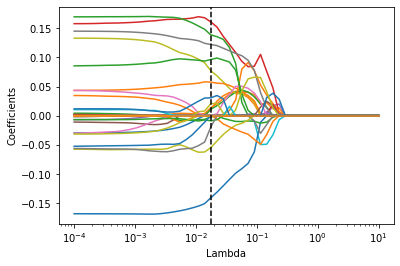

In [22]:
#lasso特征筛选nx
alphas = np.logspace(-4,1,100)
model_lassoCV = LassoCV(alphas = alphas, max_iter = 100000).fit(X_x,y_x)
coef = pd.Series(model_lassoCV.coef_, index = X_x.columns)
index = coef[coef != 0].index
X_x_raw = X_x
X_x = X_x[index]

#lasso图-特征系数随Lambda变化曲线
coefs = model_lassoCV.path(X_x_raw,y_x,alphas = alphas, max_iter = 100000)[1].T
plt.figure()
plt.semilogx(model_lassoCV.alphas_,coefs, '-')
plt.axvline(model_lassoCV.alpha_,color = 'black',ls="--")
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.show()

### VIF

In [23]:
#VIF 
def VIF(X, thres):
    col = list(range(X.shape[1]))
    dropped = len(col)
    
    for var in range(0,dropped):
        x_new=X.iloc[:, col]
        vif = [variance_inflation_factor(X.iloc[:, col].values, ix) for ix in range(X.iloc[:, col].shape[1])]
        col_all=col
        maxvif = max(vif)
        maxix = vif.index(maxvif)
        if maxvif > thres:
            del col[maxix]
            print('deleted:',x_new.columns[maxix],'；','VIF:',maxvif)         
        Xnew=X.iloc[:, col]        
        
    print('Remain Variables:', len(X.columns[col]))
    return Xnew

### Lasso选值图

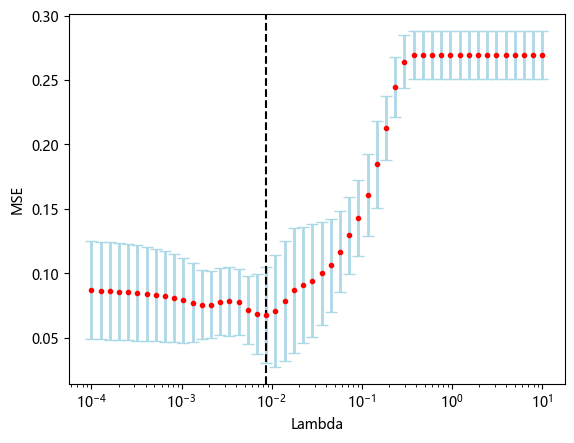

In [46]:
#lasso特征筛选nd
alphas = np.logspace(-4,1,50)
model_lassoCV = LassoCV(alphas = alphas, max_iter = 100000).fit(X_d,y_d)
coef = pd.Series(model_lassoCV.coef_, index = X_d.columns)
index = coef[coef != 0].index
X_d_raw = X_d
X_d = X_d[index]

#LASSO模型中Lambda选值图
MSEs = model_lassoCV.mse_path_
MSEs_mean, MSEs_std = [], []
for i in range(len(MSEs)):
    MSEs_mean.append(MSEs[i].mean())
    MSEs_std.append(MSEs[i].std())
plt.figure()
plt.errorbar(model_lassoCV.alphas_,MSEs_mean    
             , yerr=MSEs_std                    #y误差范围
             , fmt="o"                          #数据点标记
             , ms=3                             
             , mfc="r"                          
             , mec="r"                         
             , ecolor="lightblue"               #误差棒设置
             , elinewidth=2                    
             , capsize=4                        
             , capthick=1)                      
plt.semilogx()
plt.axvline(model_lassoCV.alpha_,color = 'black',ls="--")
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.show()

In [48]:
#nd VIF
x=X_d.iloc[:,1:]
X_d = VIF(x,thres=10.0)

deleted: T2-L-log-sigma-4-0-mm-3D_firstorder_InterquartileRange ； VIF: 4010.4870214820544
deleted: T2-L-log-sigma-4-0-mm-3D_glcm_MaximumProbability ； VIF: 36.54718836956581
deleted: T1-L-squareroot_glcm_ClusterTendency ； VIF: 22.501977931413833
deleted: T2-L-logarithm_firstorder_RobustMeanAbsoluteDeviation ； VIF: 14.486501046318905
deleted: T2-L-log-sigma-3-0-mm-3D_firstorder_InterquartileRange ； VIF: 11.36883766026915
Remain Variables: 12


### 特征相关性可视化

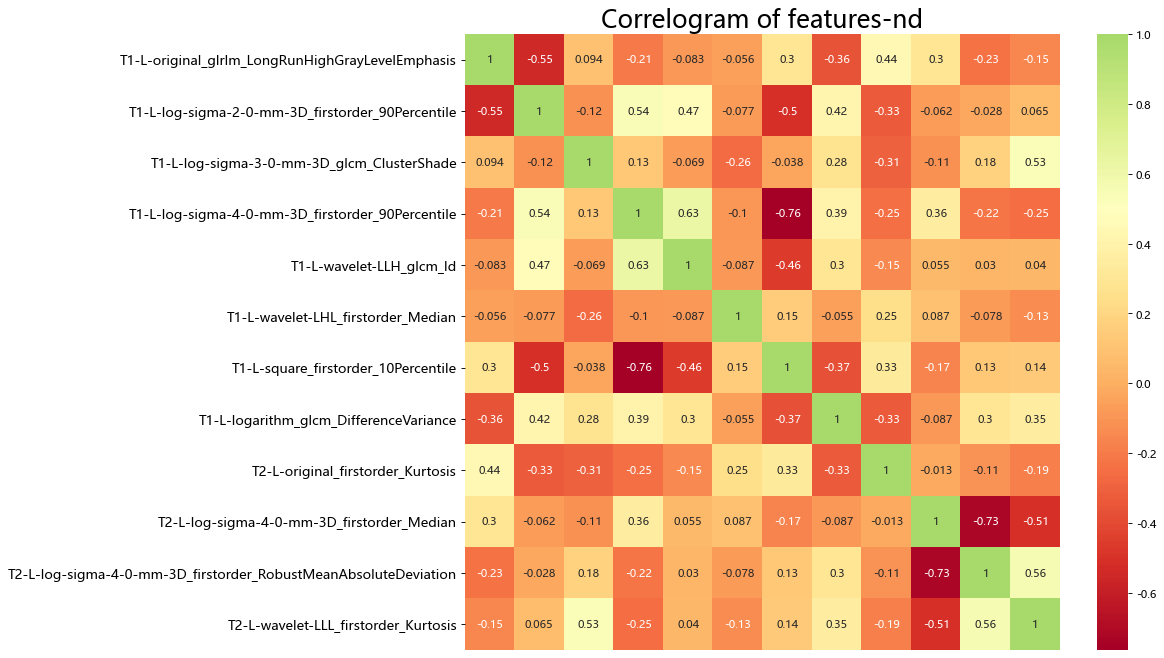

In [49]:
#绘制热图
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(X_d.corr()                         #计算特征间的相关性
            , xticklabels=False
            , yticklabels=X_d.corr().columns
            , cmap='RdYlGn'
            , center=0.5
            , annot=True)
plt.title('Correlogram of features-nd', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 绘制箱型图

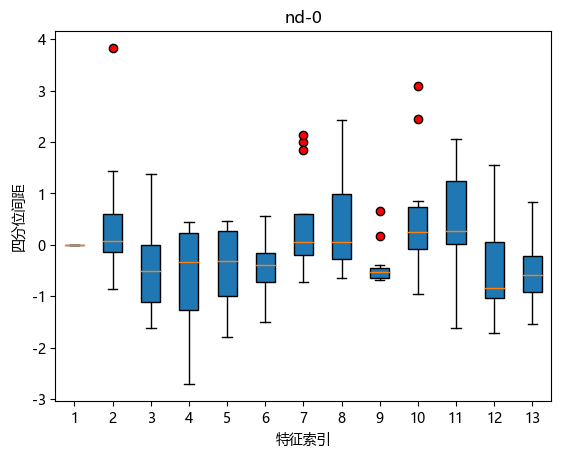

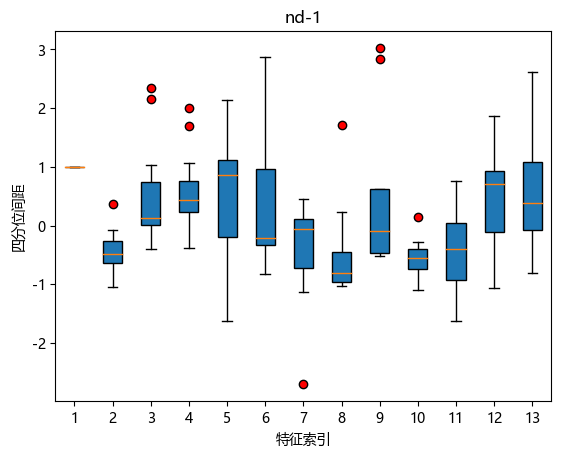

In [55]:
#箱型图1与2-nd
# #绘制箱线图0
X_a = X_x[:][X_y['label'] == 0]
box_data = np.array(X_a)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

plt.boxplot(x = box_data, 
 
             patch_artist=True, # 自定义颜色填充盒形图
 
             flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}) # 设置异常值属性，点的形状、填充色和边框色
 
plt.xlabel("特征索引")
plt.ylabel("四分位间距")
plt.title("nd-0")
plt.show()
# #绘制箱线图1
X_b = a[:][a['label'] == 1]
box_data = np.array(X_b)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

plt.boxplot(x = box_data,
 
             patch_artist=True, 
 
             flierprops = {'marker':'o','markerfacecolor':'red','color':'black'})
 
plt.xlabel("特征索引")
plt.ylabel("四分位间距")
plt.title("nd-1")
plt.show()